# Impact of Qualifying Position on Race Performance

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
qualifying = pd.read_csv('qualifying.csv')
results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')

# Merge the dataframes and choose relevant columns

In [64]:
merged_df = pd.merge(qualifying, results[['raceId', 'driverId', 'positionOrder', 'points']], on=['raceId', 'driverId'], how='left')

merged_df['q3'].replace('\\N', np.nan, inplace=True)
merged_df['q2'].replace('\\N', np.nan, inplace=True)
merged_df['q1'].replace('\\N', np.nan, inplace=True)


# Convert q1, q2, q3 times to milliseconds
def time_to_milliseconds(time_str):
    try:
        if pd.isna(time_str):
            return None
        minutes, seconds_millis = time_str.split(':')
        seconds, milliseconds = seconds_millis.split('.')
        total_milliseconds = (int(minutes) * 60 * 1000) + \
            (int(seconds) * 1000) + int(milliseconds)
        return total_milliseconds
    except ValueError as e:
        print(f"Error converting time: {time_str}, error: {e}")
        return None


merged_df['q1_milliseconds'] = merged_df['q1'].apply(time_to_milliseconds)
merged_df['q2_milliseconds'] = merged_df['q2'].apply(time_to_milliseconds)
merged_df['q3_milliseconds'] = merged_df['q3'].apply(time_to_milliseconds)

# Select relevant columns for analysis
final_df = merged_df[['raceId', 'driverId', 'constructorId', 'q1_milliseconds','q2_milliseconds', 'q3_milliseconds', 'points', 'positionOrder']]

# Display the final dataframe
print(final_df.head())

# Save the cleaned dataset for further analysis
final_df.to_csv('f1_qualifying_race_performance.csv', index=False)

   raceId  driverId  constructorId  q1_milliseconds  q2_milliseconds  \
0      18         1              1          86572.0          85187.0   
1      18         9              2          86103.0          85315.0   
2      18         5              1          85664.0          85452.0   
3      18        13              6          85994.0          85691.0   
4      18         2              2          85960.0          85518.0   

   q3_milliseconds  points  positionOrder  
0          86714.0    10.0              1  
1          86869.0     0.0              9  
2          87079.0     4.0              5  
3          87178.0     0.0             13  
4          87236.0     8.0              2  


C:\Users\domin\AppData\Local\Temp\ipykernel_15112\51113402.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['q3'].replace('\\N', np.nan, inplace=True)
C:\Users\domin\AppData\Local\Temp\ipykernel_15112\51113402.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [65]:
final_df.shape

(9815, 8)

In [66]:
final_df.head()

,raceId,driverId,constructorId,q1_milliseconds,q2_milliseconds,q3_milliseconds,points,positionOrder
0,18,1,1,86572.0,85187.0,86714.0,10.0,1
1,18,9,2,86103.0,85315.0,86869.0,0.0,9
2,18,5,1,85664.0,85452.0,87079.0,4.0,5
3,18,13,6,85994.0,85691.0,87178.0,0.0,13
4,18,2,2,85960.0,85518.0,87236.0,8.0,2


In [67]:
print(final_df.dtypes)
final_df = final_df.dropna(
    subset=['q1_milliseconds', 'q2_milliseconds', 'q3_milliseconds'])
final_df.isna().sum()

raceId               int64
driverId             int64
constructorId        int64
q1_milliseconds    float64
q2_milliseconds    float64
q3_milliseconds    float64
points             float64
positionOrder        int64
dtype: object


raceId             0
driverId           0
constructorId      0
q1_milliseconds    0
q2_milliseconds    0
q3_milliseconds    0
points             0
positionOrder      0
dtype: int64

In [72]:
final_df.shape

(3297, 8)

In [70]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
raceId,3297.0,743.772520,397.595513,1.0,350.0,930.0,1019.0,1110.0
driverId,3297.0,346.404914,399.159260,1.0,8.0,20.0,822.0,857.0
constructorId,3297.0,43.485593,68.353369,1.0,4.0,7.0,51.0,214.0
q1_milliseconds,3297.0,88213.873218,12410.109595,53904.0,78117.0,87374.0,96517.0,131081.0
q2_milliseconds,3297.0,87511.797392,12114.908593,53647.0,77652.0,86889.0,96143.0,129272.0
q3_milliseconds,3297.0,87759.942675,12381.439551,53377.0,77549.0,87286.0,96242.0,129776.0
points,3297.0,7.970731,7.761998,0.0,0.0,6.0,12.0,50.0
positionOrder,3297.0,7.619958,5.925939,1.0,3.0,6.0,10.0,24.0


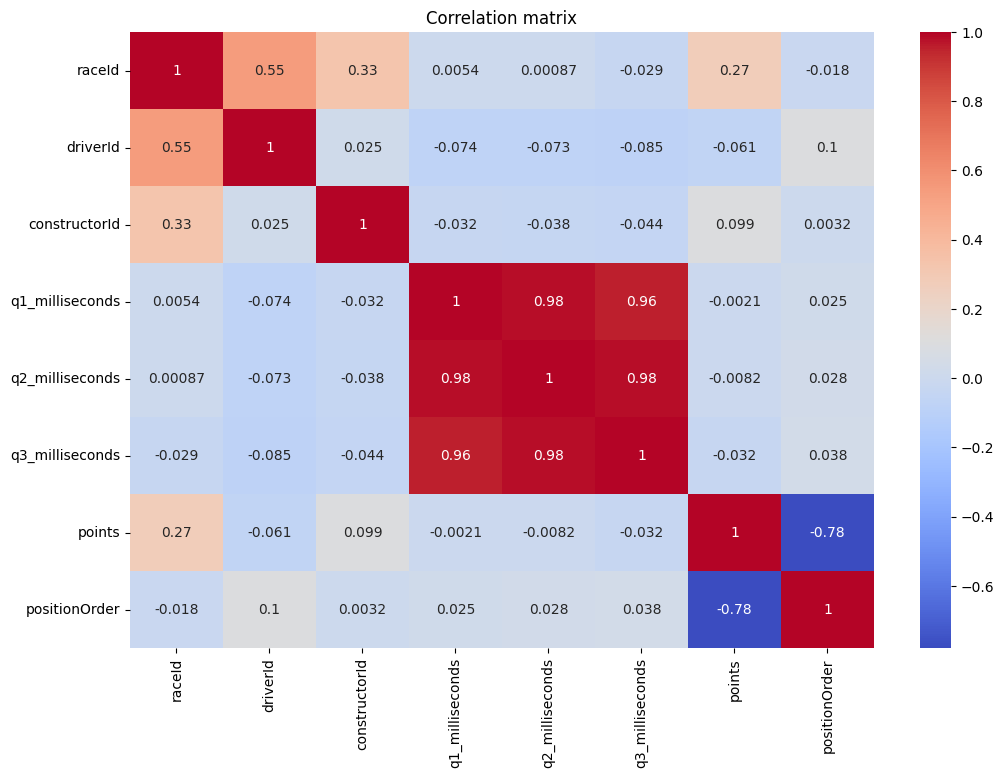

In [71]:
correct_columns = final_df.select_dtypes(include=['float', 'int'])
correlation_matrix = correct_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

### Zmienna objaśniana - points
### Zmienna objaśniająca - positionOrder, raceId